In [1]:
import pandas as pd
from gwpy.timeseries import TimeSeries
import pycbc
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
from scipy import stats

/home/ashishmathew0297/miniconda3/envs/gengli_env/lib/python3.12/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


We load the CSV that contains all glitch times from the first half of the third observing run.

In [2]:
glitches = pd.read_csv('./data/O3a_allifo.csv')
glitches.columns

Index(['GPStime', 'peakFreq', 'snr', 'amplitude', 'centralFreq', 'duration',
       'bandwidth', 'chisq', 'chisqDof', 'confidence', 'id', 'ifo', 'label',
       'imgUrl', 'Q-value'],
      dtype='object')

In [3]:
glitches.shape

(198455, 15)

As you can see it contains a bunch of columns. 
- **GPStime**: The timestamp in GPS format indicating the event time.
- **peakFreq**: The frequency at which the signal has the highest intensity.
- **snr**: Signal-to-noise ratio, indicating the clarity of the signal.
- **amplitude**: The strength or height of the signal wave.
- **centralFreq**: The central frequency of the signal's spectral content.
- **duration**: The time span of the signal event.
- **bandwidth**: The range of frequencies covered by the signal.
- **chisq**: The chi-squared statistic for assessing signal fit quality.
- **chisqDof**: The degrees of freedom used in the chi-squared test.
- **confidence**: The likelihood or certainty of the detection.
- **id**: A unique identifier for the signal event.
- **ifo**: The interferometer associated with the signal detection.
- **label**: Classification or annotation of the event.
- **imgUrl**: Link to an image or visual representation of the signal.
- **Q-value**: Quality factor indicating the sharpness of the signal.

Let's take a look at the **label** column to see all the different glitch classes.

In [ ]:
glitches['label'].unique()

array(['Extremely_Loud', 'Scattered_Light', 'Scratchy',
       'Power_Line', 'Koi_Fish', 'Whistle',
       'Low_Frequency_Burst', 'Tomte', 'Repeating_Blips',
       'Fast_Scattering', 'Blip', 'Blip_Low_Frequency',
       'Violin_Mode', 'Helix', 'None_of_the_Above',
       'Low_Frequency_Lines', 'Wandering_Line', 'No_Glitch',
       'Air_Compressor', 'Chirp', 'Light_Modulation',
       'Paired_Doves', '1400Ripples', '1080Lines'], dtype=object)

As a dummy example let's select 'Tomte' glitches from LIGO Livingston (L1)

In [5]:
selected = glitches[(glitches['label'] == 'Tomte') & (glitches['ifo'] == 'L1')]
len(selected), len(selected)

(20804, 20804)

In [6]:
np.round(np.mean(selected['duration'].values), 2)

np.float64(0.66)

You can see that 'Tomte' of 'L1' is a subset of the initial data set. How long are they?

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1785/779566470.py:2: SyntaxWarning: invalid escape sequence '\m'
  label=f'$\mu=$'+str(np.round(np.mean(selected['duration'].values), 3))+' s')


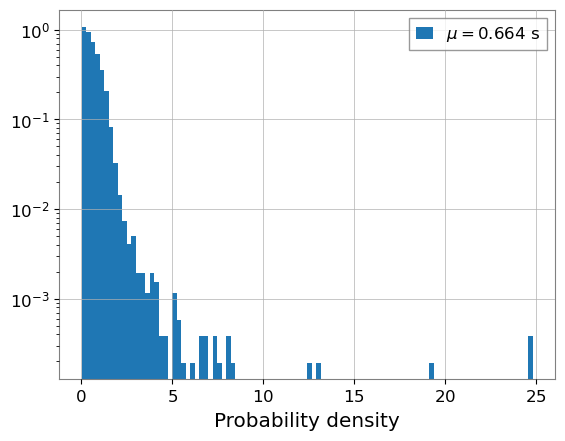

In [7]:
plt.hist(selected['duration'].values, bins=100, density=True,
         label=f'$\mu=$'+str(np.round(np.mean(selected['duration'].values), 3))+' s')
plt.yscale('log')
plt.xlabel('Duration (s)')
plt.xlabel('Probability density')
plt.legend()

On average they are 0.664 s long, so we can visualize then in 2s. Let's pick a random example and visualize it.

In this code block

```python
noise = TimeSeries.fetch_open_data(ifo, g_star - tw ,  g_star + tw, sample_rate=srate)
```

This fetches info from the LIGO OSC for L1 at the given gps time for 3 seconds at a sample rate of 4096 and is then converted to the pycbc format and whitened.

In [8]:
def get_noise_data(selected, srate=4096, tw=3, ifo='L1', begin=0, end=50):
    data_readings = []
    g_stars = selected['GPStime'].iloc[begin:end]

    for g_star in g_stars:
        noise = TimeSeries.fetch_open_data(ifo, g_star - tw ,  g_star + tw, sample_rate=srate)
        noise = noise.to_pycbc()
        white_noise, psd = noise.whiten(len(noise) / (2 * srate),
                                        len(noise)/( 4 * srate),
                                        remove_corrupted = False,
                                        return_psd = True)
        # Crop 1s at each side to avoid border effects
        white_noise = white_noise[int(srate * 1):-int(srate * 1)]
        data = TimeSeries(white_noise, sample_rate = srate)
        q_scan = data.q_transform(qrange=[4,64], frange=[10, 2048],
                                tres=0.002, fres=0.5, whiten=False)
        t = data.times[int(srate * 1.5):-int(srate * 1.5)]
        y = data.value[int(srate * 1.5):-int(srate * 1.5)]
        data_readings.append((y,t))
        # noise_readings.append(white_noise)

    data_df = pd.DataFrame(data_readings, columns=['y', 't'])
    return data_df

OK, now we can check its Gaussianity with Saphiro test. We test that the input time series (y) is Gaussian, against the alternative hypothesis that it is non-Gaussian. If the test yields a p-value below $\alpha=0.05$ it means that the input data is non-Gaussian

In [9]:
def display_shapiro_stats(data_df, tw):
    plt.hist(data_df['shapiro_pvalue'], bins=40)
    # plt.xscale('log')
    plt.xlabel('Shapiro p-value')
    plt.ylabel('Frequency')
    plt.xticks(list(np.arange(data_df['shapiro_pvalue'].min(), data_df['shapiro_pvalue'].max()+0.01, 0.01)), fontsize=8, rotation=90)
    # plt.xticks(np.arange(0, 0.04*tw, 0.01), fontsize=8)
    # plt.xticks(list(plt.xticks()[0]) + [0.05])
    plt.title('Histogram of Shapiro p-values for Different Glitches')
    plt.grid(True)
    plt.show()
    print(f"Number of Shapiro p-values above 0.05: {(data_df['shapiro_pvalue'] > 0.05).sum()}")
    print(f"Max Shapiro p-value: {data_df['shapiro_pvalue'].max()}")
    print(f"Min Shapiro p-value: {data_df['shapiro_pvalue'].min()}")

Changing the sampling rate increases the amount of times we smaple from the data per second. I want to know how the p-values would vary with this change. The gwpy [documentation](https://gwpy.github.io/docs/latest/api/gwpy.timeseries.TimeSeries/#gwpy.timeseries.TimeSeries.fetch_open_data) states that there can be event data with a 16384 Hz sampling rate which is what I will be using as a reference.

/home/ashishmathew0297/miniconda3/envs/gengli_env/lib/python3.12/site-packages/gwpy/signal/qtransform.py:124: UserWarning: upper frequency of 2048.00 is too high for the given Q range, resetting to 1291.05
  warnings.warn('upper frequency of %.2f is too high for the given '
/home/ashishmathew0297/miniconda3/envs/gengli_env/lib/python3.12/site-packages/gwpy/signal/qtransform.py:124: UserWarning: upper frequency of 2048.00 is too high for the given Q range, resetting to 1291.05
  warnings.warn('upper frequency of %.2f is too high for the given '


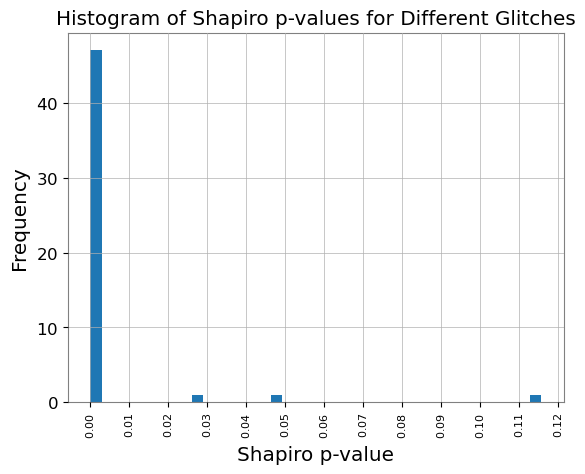

Number of Shapiro p-values above 0.05: 1
Max Shapiro p-value: 0.11571115310990238
Min Shapiro p-value: 1.6900606781882096e-33


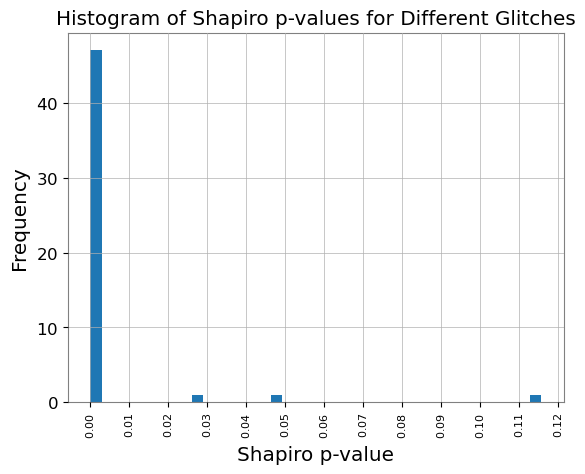

Number of Shapiro p-values above 0.05: 1
Max Shapiro p-value: 0.11571115310990193
Min Shapiro p-value: 1.6900606781882096e-33


In [10]:
def p_values_with_sample_rate():
    data_df_4096 = get_noise_data(selected, tw=3, begin=100, end=150)
    data_df_16384 = get_noise_data(selected, tw=3, begin=100, end=150)

    data_df_4096['shapiro_pvalue'] = data_df_4096['y'].apply(lambda y: stats.shapiro(y).pvalue)
    data_df_16384['shapiro_pvalue'] = data_df_16384['y'].apply(lambda y: stats.shapiro(y).pvalue)
    
    display_shapiro_stats(data_df_4096, 3)
    display_shapiro_stats(data_df_16384, 3)

    return data_df_4096, data_df_16384


data_df_4096, data_df_16384 = p_values_with_sample_rate()


We notice here that the sampling rate does not seem to change the p-values of the shapiro test. Below, we look a bit closer at the histogram to confirm that there is not change whatsoever.

In [11]:
def view_filtered_histograms(threshold = 0.06):
    filtered_4096 = data_df_4096[data_df_4096['shapiro_pvalue'] <= threshold]
    filtered_16384 = data_df_16384[data_df_16384['shapiro_pvalue'] <= threshold]

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    ax[0].hist(filtered_4096['shapiro_pvalue'], bins=30)
    ax[0].set_xlabel("Shapiro p-value")
    ax[0].set_ylabel("Frequency")
    ax[0].set_title("Shapiro p-values ≤ 0.01 (data_df_4096)")


    ax[1].hist(filtered_16384['shapiro_pvalue'], bins=30)
    ax[1].set_xlabel("Shapiro p-value")
    ax[1].set_ylabel("Frequency")
    ax[1].set_title("Shapiro p-values ≤ 0.01 (data_df_4096)")
    plt.show()



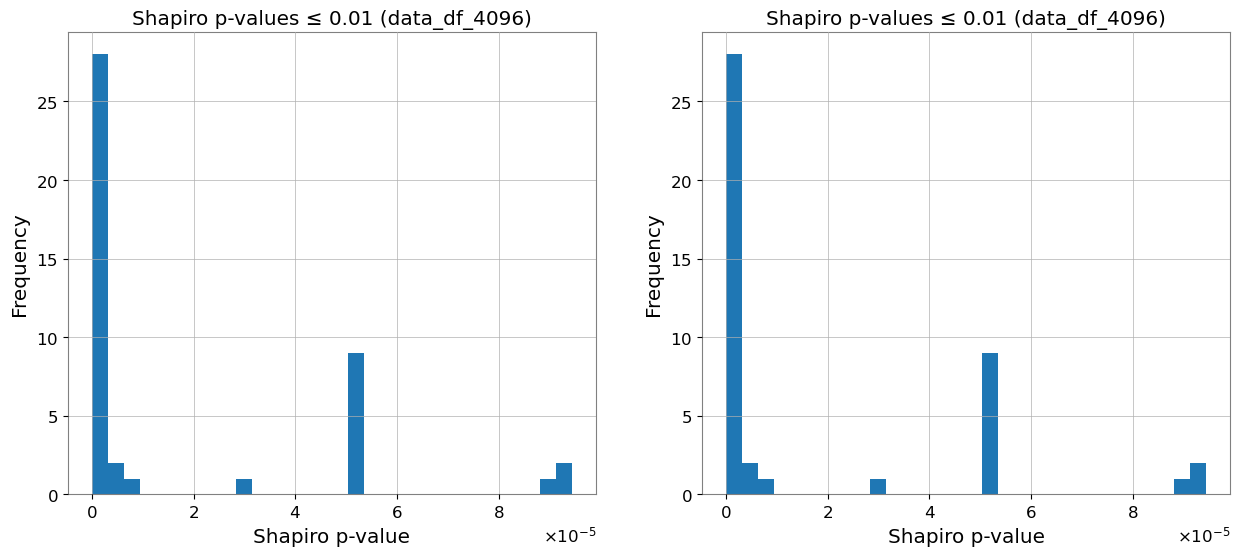

In [12]:
view_filtered_histograms(0.0001)

We also check the equality of the numpy arrays to 100% confirm that the distributions are the same. Here we see that the p-values differ and they differ by a small margin (in the scale of $10^-15$) at to points. This could most probably be chalked up to floating point precision errors.

In [18]:
data_df_4096['shapiro_pvalue'].equals(data_df_16384['shapiro_pvalue'])

False

In [19]:
difference = data_df_4096['shapiro_pvalue'] - data_df_16384['shapiro_pvalue']

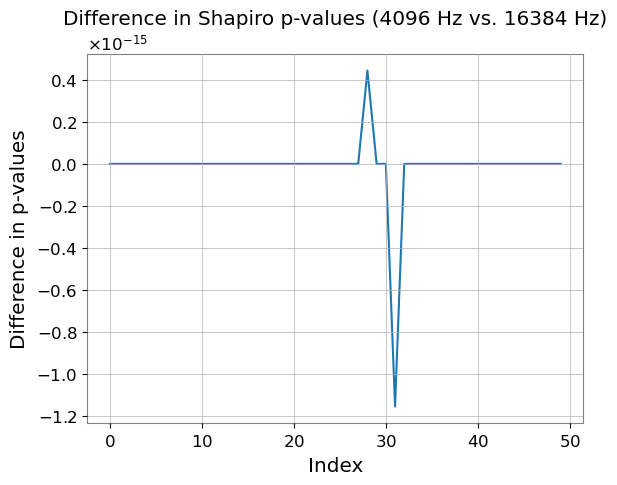

In [24]:
plt.plot(difference)
plt.xlabel("Index")
plt.ylabel("Difference in p-values")
plt.title("Difference in Shapiro p-values (4096 Hz vs. 16384 Hz)")
plt.show()

Next would be checking the timeframe over which we conduct the test. This is more likely to change the shapiro values as we are increasing the number of points over which we are doing these calculations.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].hist(filtered_4096['shapiro_pvalue'], bins=30)
ax[0].set_xlabel("Shapiro p-value")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Shapiro p-values ≤ 0.01 (data_df_4096)")


ax[1].hist(filtered_16384['shapiro_pvalue'], bins=30)
ax[1].set_xlabel("Shapiro p-value")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Shapiro p-values ≤ 0.01 (data_df_4096)")
plt.show()

/home/ashishmathew0297/miniconda3/envs/gengli_env/lib/python3.12/site-packages/gwpy/signal/qtransform.py:124: UserWarning: upper frequency of 2048.00 is too high for the given Q range, resetting to 1291.05
  warnings.warn('upper frequency of %.2f is too high for the given '
/home/ashishmathew0297/miniconda3/envs/gengli_env/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12288.
  res = hypotest_fun_out(*samples, **kwds)
/home/ashishmathew0297/miniconda3/envs/gengli_env/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20480.
  res = hypotest_fun_out(*samples, **kwds)


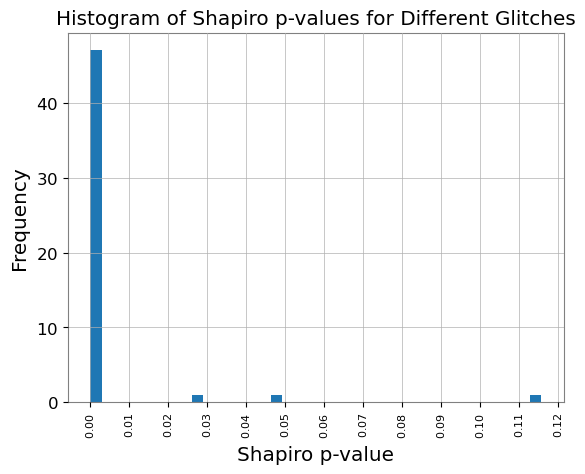

Number of Shapiro p-values above 0.05: 1
Max Shapiro p-value: 0.11571115310990193
Min Shapiro p-value: 1.6900606781882096e-33


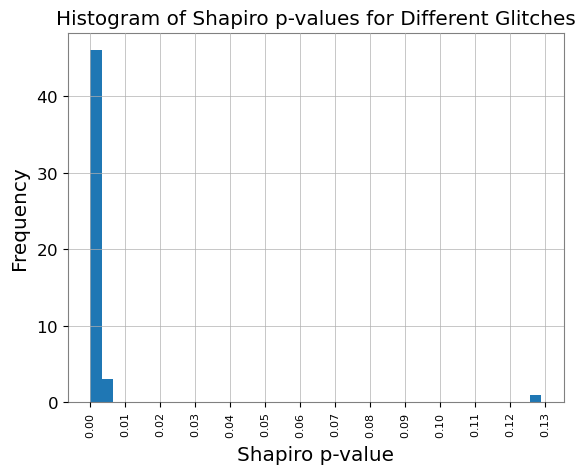

Number of Shapiro p-values above 0.05: 1
Max Shapiro p-value: 0.12885757627648853
Min Shapiro p-value: 6.5413948346530956e-15


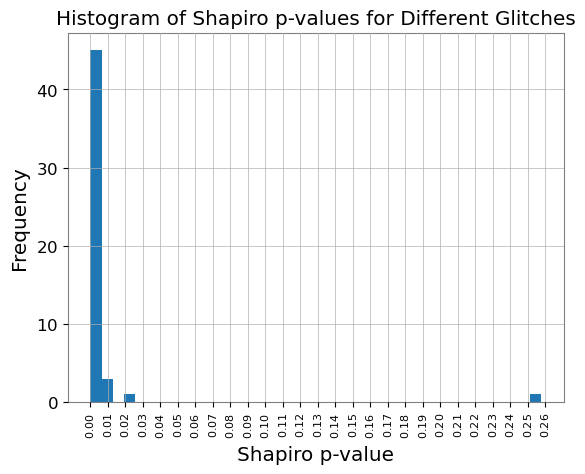

Number of Shapiro p-values above 0.05: 1
Max Shapiro p-value: 0.2575672021619787
Min Shapiro p-value: 7.229078175909559e-15


In [11]:
def p_values_with_time_width():
    data_df_3 = get_noise_data(selected, tw=3, begin=100, end=150)
    data_df_4 = get_noise_data(selected, tw=4, begin=100, end=150)
    data_df_5 = get_noise_data(selected, tw=5, begin=100, end=150)

    data_df_3['shapiro_pvalue'] = data_df_3['y'].apply(lambda y: stats.shapiro(y).pvalue)
    data_df_4['shapiro_pvalue'] = data_df_4['y'].apply(lambda y: stats.shapiro(y).pvalue)
    data_df_5['shapiro_pvalue'] = data_df_5['y'].apply(lambda y: stats.shapiro(y).pvalue)
    
    display_shapiro_stats(data_df_3, 3)
    display_shapiro_stats(data_df_4, 4)
    display_shapiro_stats(data_df_5, 5)

    return data_df_3, data_df_4, data_df_5


data_df_3, data_df_4, data_df_5 = p_values_with_time_width()

My hunch was right. The p-values have changed. This could probably be because we are considering more data points as we increase the time window.